In [1]:
from load import load_all_sis_data
import numpy as np

# Load all data
all_flux_data, datetime_values, element_mapping = load_all_sis_data('flux_1998/')

print("All data shape:", all_flux_data.shape)
print("Element Mapping:", element_mapping, "\n")

# Precompute the Q1 values for each element
energy_level_to_compute = 1
q1_values = {}
for element_name, element_index in element_mapping.items():
    valid_data_mask = (all_flux_data[energy_level_to_compute - 1, :, element_index] != -999.9) & (all_flux_data[energy_level_to_compute - 1, :, element_index] != 0)
    element_flux_for_stats = all_flux_data[energy_level_to_compute - 1, :, element_index][valid_data_mask]
    if len(element_flux_for_stats) > 0:
        q1_values[element_name] = np.percentile(element_flux_for_stats, 25)

# multiplier for He and O to account for abundance
q1_values["He"] *= 3
q1_values["O"] *= 2.25
print("Q1 Cutoffs: ", q1_values)

# These values will be used as the lower cutoff for decay event identification
he_flux_threshold = q1_values["He"]
o_flux_threshold = q1_values["O"]

All data shape: (8, 231864, 6)
Element Mapping: {'C': 0, 'Fe': 1, 'He': 2, 'N': 3, 'O': 4, 'Si': 5} 

Q1 Cutoffs:  {'C': 5.6207e-06, 'Fe': 1.97605e-06, 'He': 9.619200000000002e-05, 'N': 3.73e-06, 'O': 7.82685e-06, 'Si': 2.8857e-06}



---

The `compute_decay_events_for_all_data` function utilizes the `identify_exponential_decays` function to find decay events within the entire data range based on Helium flux at an energy level defined by `energy_level_to_compute`. The computed event windows are then stored in a Pandas dataframe. Keeps only events that are longer than the defined hours **and** where the helium (reference) flux stays above the threshold for the specified duration, then disregards the rest.

Then, for each of the other elements, the `count_elements_decaying_in_window` function determines whether or not it is also decaying within the event window, and appends two columns to the dataframe.

Currently, `he_flux_threshold` is defined as 3 times the Q1 upper bound for helium flux data

In [2]:
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy.stats import linregress

"""The function below uses a sliding window approach, where a fixed-size w
indow (specified by `window_size`) is moved across the logarithmic flux data. 
For each position of the window, linear regression is performed on the data 
within the window. The regression line's slope is computed, and if this slope 
is less than a predefined threshold (`slope_threshold`), it indicates a 
significant downward trend, characteristic of an exponential decay. The start 
and end times of the window are recorded as a decay segment if the slope condition is met."""

"""After identifying all potential decay segments, it proceeds to merge overlapping or 
adjacent segments. This step ensures that a continuous decay period is not fragmented 
into multiple segments. The merging process checks if the start time of a new segment 
is within the current segment being considered. If the segments are close enough 
(considering the flux increase threshold), they are merged into a single continuous segment. 
This merging is done iteratively to cover all identified decay periods."""



def identify_exponential_decays(flux_data, time_data, window_size, slope_threshold, r_value_threshold):
    """
    Identifies exponential decay segments in flux data using linear regression.

    Args:
        flux_data (numpy.ndarray): Array of flux values.
        time_data (numpy.ndarray): Array of corresponding datetime values.
        window_size (int): Size of the sliding window for linear regression (in hours).
        slope_threshold (float): Threshold for the slope to identify a decay.
        r_value_threshold (float): Minimum correlation coefficient (r-value) for considering a fit.

    Returns:
        list: List of tuples containing start and end times of decay segments.
    """
    # Replace non-positive flux values with NaN for logarithmic transformation
    flux_data = np.where(flux_data > 0, flux_data, np.nan)
    
    # Log-transform the flux data
    log_flux_data = np.log10(flux_data)
    
    # Apply Gaussian smoothing to the log-transformed flux data
    log_flux_data = gaussian_filter1d(log_flux_data, sigma=1)

    decays = []
    # Iterate over the data using a sliding window
    for i in range(len(log_flux_data) - window_size):
        window = log_flux_data[i:i + window_size]
        
        # Skip windows with NaN values
        if np.isnan(window).any():
            continue
        
        # Perform linear regression on the windowed data
        slope, intercept, r_value, p_value, std_err = linregress(np.arange(window_size), window)
        
        # Check if the slope and correlation coefficient meet the decay criteria
        if slope < slope_threshold and abs(r_value) > r_value_threshold:
            start_time = time_data[i]
            end_time = time_data[i + window_size - 1]
            decays.append((start_time, end_time))

    # Merge overlapping decay segments
    merged_decays = []
    for start, end in decays:
        if merged_decays and start <= merged_decays[-1][1] + (time_data[1] - time_data[0]):
            merged_decays[-1] = (merged_decays[-1][0], max(merged_decays[-1][1], end))
        else:
            merged_decays.append((start, end))

    return merged_decays


def count_elements_decaying_in_window(data_3d, datetime_values, element_mapping, energy_level, start_time, end_time, window_size_for_decay_count, slope_threshold, r_value_threshold):
    """
    Counts the number of elements with exponential decays within a given time window.
    
    Args:
        data_3d (numpy.ndarray): The 3D data cube (energy, time, element).
        datetime_values (numpy.ndarray): Array of datetime objects.
        element_mapping (dict): Element name to array index mapping.
        energy_level (int): The energy level to analyze.
        start_time (pd.Timestamp): Start time for the time window.
        end_time (pd.Timestamp): End time for the time window.
        window_size_for_decay_count (int): Size of the sliding window for decay detection (in hours).
        slope_threshold (float): Threshold for the slope to identify a decay.
        r_value_threshold (float): Minimum correlation coefficient (r-value) for considering a fit.

    Returns:
        set: The set of elements that decay within the time window.
    """
    # Create a time mask to filter data within the specified time window
    time_mask = (datetime_values >= start_time) & (datetime_values <= end_time)
    decaying_elements = set()

    # Iterate through each element (excluding helium) to check for decays
    for element_name, element_index in element_mapping.items():
        if element_name == 'He':
            continue

        # Extract the flux data for the current element within the time window
        element_flux = data_3d[energy_level - 1, time_mask, element_index]
        
        # Mask invalid data values
        valid_data_mask = element_flux != -999.9
        element_flux = element_flux[valid_data_mask]
        element_time = datetime_values[time_mask][valid_data_mask]

        if len(element_flux) == 0:
            continue

        # Identify decay segments for the current element
        decays = identify_exponential_decays(element_flux, element_time, window_size_for_decay_count, slope_threshold, r_value_threshold)
        
        # If decays are found, add the element to the decaying elements set
        if len(decays) > 0:
            decaying_elements.add(element_name)

    return decaying_elements


def compute_decay_events_for_all_data(data_3d, datetime_values, element_mapping, energy_level, he_flux_threshold, min_duration_hours, window_size, window_size_for_decay_count, slope_threshold, r_value_threshold):
    """
    Computes decay events for all available data, keeping only events where helium flux stays above the threshold
    for the specified duration, and counts the number of elements with exponential decays in each window.

    This function utilizes "identify_exponential_decays" and "count_elements_decaying_in_window"
    
    Args:
        data_3d (numpy.ndarray): The 3D data cube (energy, time, element).
        datetime_values (numpy.ndarray): Array of datetime objects.
        element_mapping (dict): Element name to array index mapping.
        energy_level (int): The energy level to analyze.
        he_flux_threshold (float): Minimum helium flux threshold.
        min_duration_hours (int): Minimum duration (hours) above threshold.
        window_size (int): Size of the sliding window for decay detection (in hours).
        window_size_for_decay_count (int): Size of the sliding window for counting decaying elements (in hours).
        slope_threshold (float): Threshold for the slope to identify a decay.
        r_value_threshold (float): Minimum correlation coefficient (r-value) for considering a fit.

    Returns:
        pd.DataFrame: DataFrame with decay event details including the number of elements decaying and non-decaying elements.
    """
    print("STARTING...")

    # Extract helium flux data
    helium_index = element_mapping['He']
    helium_flux = data_3d[energy_level - 1, :, helium_index]
    
    # Mask invalid helium flux data
    valid_data_mask = helium_flux != -999.9
    helium_flux = helium_flux[valid_data_mask]
    helium_time = datetime_values[valid_data_mask]
    
    if len(helium_flux) == 0:
        print("No valid helium data available.")
        return pd.DataFrame()
    
    # Identify decay segments in helium flux data
    decay_segments = identify_exponential_decays(helium_flux, helium_time, window_size, slope_threshold, r_value_threshold)
    decay_event_details = []

    # Set of all elements excluding helium
    all_elements = set(element_mapping.keys()) - {'He'}

    for event_number, (start, end) in enumerate(decay_segments):
        current_event_duration_hours = (end - start) / np.timedelta64(1, 'h')


        start_index = np.where(helium_time == start)[0][0]
        end_index = np.where(helium_time == end)[0][0]
        
        start_flux = helium_flux[start_index]
        end_flux = helium_flux[end_index]

        if start_flux > end_flux:
            print("start scanning...")
            shift_duration = pd.Timedelta(hours=max(4, int(current_event_duration_hours / 15)))
            previous_start_flux = start_flux 
            
            while start_flux > end_flux:
                # print(f"Current start flux: {start_flux}")
                # print(f"End flux: {end_flux}")

                shifted_start = start - shift_duration
                
                # Find the closest time in helium_time that's not later than shifted_start
                shifted_start_index = np.where(helium_time <= shifted_start)[0]
                
                if len(shifted_start_index) == 0:
                    # print("Reached the beginning of the data. Stopping shift.")
                    break
                
                shifted_start_index = shifted_start_index[-1]
                shifted_start = helium_time[shifted_start_index]
                new_start_flux = helium_flux[shifted_start_index]
                
                # print(f"Shifted start time: {shifted_start}")
                # print(f"New start flux: {new_start_flux}")
                
                if new_start_flux < previous_start_flux:
                    start = shifted_start
                    start_flux = new_start_flux
                    previous_start_flux = new_start_flux
                    start_index = shifted_start_index
                else:
                    # print("Flux increased. Stopping shift.")
                    break


        # Check how long helium flux remains above the threshold
        above_threshold_mask = helium_flux[start_index:end_index] >= he_flux_threshold
        above_threshold_times = helium_time[start_index:end_index][above_threshold_mask]

        duration_above_threshold = 0
        if len(above_threshold_times) > 1:
            time_differences = np.diff(above_threshold_times)
            continuous_periods = np.where(time_differences <= pd.Timedelta(hours=1))[0]
            if len(continuous_periods) > 0:
                duration_above_threshold = (
                    above_threshold_times[continuous_periods[-1] + 1] - above_threshold_times[0]
                ).total_seconds() / 3600

        # Count the number of elements decaying in the current time window
        decaying_elements = count_elements_decaying_in_window(
            data_3d, datetime_values, element_mapping, energy_level, start, end, window_size_for_decay_count, slope_threshold, r_value_threshold
        )

        # Identify non-decaying elements
        non_decaying_elements = all_elements - decaying_elements
        non_decaying_elements_list = list(non_decaying_elements)

        # Record the event if it meets the minimum duration requirement
        if duration_above_threshold >= min_duration_hours:
            start_year = start.year
            end_year = end.year
            start_frac_day = (
                start.timetuple().tm_yday
                + start.hour / 24
                + start.minute / 1440
                + start.second / 86400
            )
            end_frac_day = (
                end.timetuple().tm_yday
                + end.hour / 24
                + end.minute / 1440
                + end.second / 86400
            )
            start_hour = start.hour + start.minute / 60 + start.second / 3600
            end_hour = end.hour + end.minute / 60 + end.second / 3600

            # Append event details to the decay event list
            decay_event_details.append(
                {
                    "Event Number": event_number + 1,
                    "Start Year": start_year,
                    "End Year": end_year,
                    "Start Fractional Day": start_frac_day,
                    "End Fractional Day": end_frac_day,
                    "Start Hour": start_hour,
                    "End Hour": end_hour,
                    "Elements Decaying": len(decaying_elements) + 1,
                    "Non-Decaying Elements": non_decaying_elements_list,
                }
            )


    # Convert the decay event details list to a DataFrame for further analysis
    return pd.DataFrame(decay_event_details)













import pandas as pd
# from identification import compute_decay_events_for_all_data

# Define parameters for decay detection and event counting
energy_level_to_compute = 1
min_duration_hours = 48
window_size = 24  # hours for detecting decays in He flux
window_size_for_decay_count = 18  # hours for counting decaying elements
slope_threshold = -0.005
r_value_threshold = 0.5

# Compute decay events using the defined parameters
decay_events_df = compute_decay_events_for_all_data(all_flux_data, datetime_values, element_mapping, energy_level_to_compute, he_flux_threshold, min_duration_hours, window_size, window_size_for_decay_count, slope_threshold, r_value_threshold)

# Fix columns from wrapping
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')

# Print and save the decay events DataFrame
print(decay_events_df)
decay_events_df.to_csv('transformed_data/uncleaned_decay_events_98.csv', index=False)

STARTING...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning...
start scanning..

The code below will make two plots:

* Scatterplot: The x-axis represents the event number, and the y-axis represents the duration of each event in days.
* Histogram: This plot shows the distribution of event durations

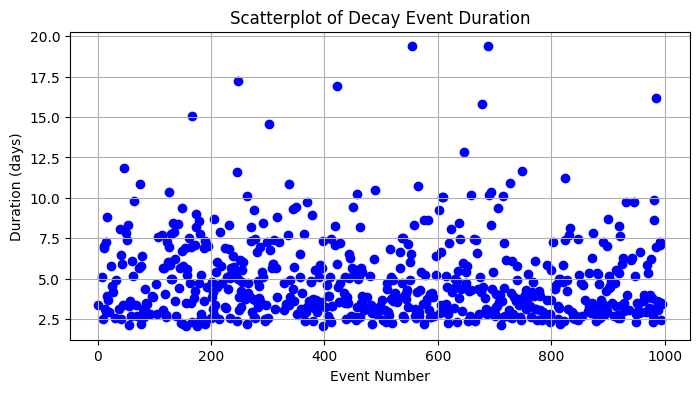

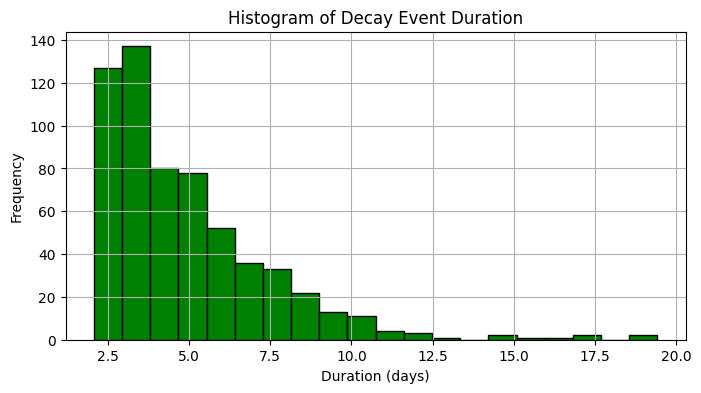

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the duration in days
decay_events_df['Duration (days)'] = (decay_events_df['End Year'] - decay_events_df['Start Year']) * 365 + (decay_events_df['End Fractional Day'] - decay_events_df['Start Fractional Day'])

# Plotting a scatterplot of the duration
plt.figure(figsize=(8, 4))
plt.scatter(decay_events_df['Event Number'], decay_events_df['Duration (days)'], color='blue')
plt.xlabel('Event Number')
plt.ylabel('Duration (days)')
plt.title('Scatterplot of Decay Event Duration')
plt.grid(True)
plt.show()

# Plotting a histogram of the duration
plt.figure(figsize=(8, 4))
plt.hist(decay_events_df['Duration (days)'], bins=20, color='green', edgecolor='black')
plt.xlabel('Duration (days)')
plt.ylabel('Frequency')
plt.title('Histogram of Decay Event Duration')
plt.grid(True)
plt.show()


Code below plots a histogram of the number of elements decaying per event found. It seems like He-only events make up the vast majority of events identified, but this might be due to bias caused by using He as the reference element when determining cutoffs, as well as He being much more abundnant.

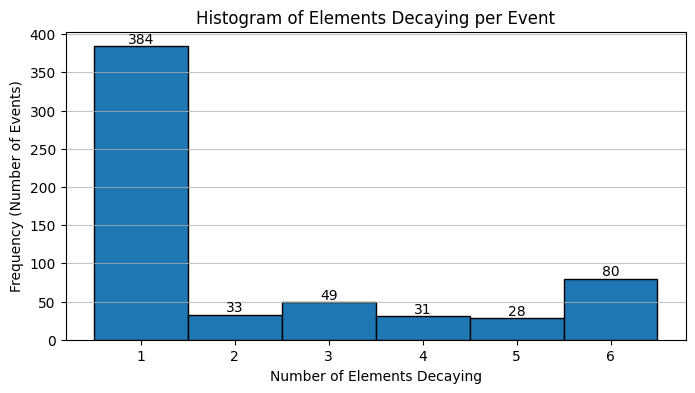

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Plotting the histogram
plt.figure(figsize=(8, 4))
counts, bins, patches = plt.hist(decay_events_df['Elements Decaying'], bins=range(1, decay_events_df['Elements Decaying'].max() + 2), align='left', edgecolor='black')
plt.title('Histogram of Elements Decaying per Event')
plt.xlabel('Number of Elements Decaying')
plt.ylabel('Frequency (Number of Events)')
plt.xticks(range(1, decay_events_df['Elements Decaying'].max() + 1))
plt.grid(axis='y', alpha=0.75)

# Annotating the bars with their frequencies
for count, bin_edge in zip(counts, bins):
    if count > 0:
        plt.text(bin_edge, count, f'{int(count)}', ha='center', va='bottom')

plt.show()


Code below plots a grid of all the decay events found. Currently commented out because it takes a long time to run due to the large number of events.

In [5]:
# from graph import plot_all_decay_events

# energy_level_to_plot = 1
# extend_days = 1  # Adjust the number of days to extend before and after
# print(f"Graph of flux events using data from energy level {energy_level_to_plot} and using data from Helium at energy level {energy_level_to_compute} for cutoffs")
# plot_all_decay_events(decay_events_df, all_flux_data, datetime_values, element_mapping, energy_level_to_plot, extend_days, True)

Next, we filter by events that have at least 3/6 elements decaying or more. 

In [24]:
def filter_by_elements_decaying(decay_events_df, min_elements_decaying_list):
    # Filter the DataFrame based on any of the minimum thresholds
    filtered_df = decay_events_df[decay_events_df['Elements Decaying'].isin(min_elements_decaying_list)]

    # Reset the index of the filtered DataFrame
    filtered_df = filtered_df.reset_index(drop=True)
    
    # Reset event numbers starting from 1
    filtered_df.loc[:, 'Event Number'] = range(1, len(filtered_df) + 1)

    return filtered_df

min_elements_decaying_list = [2,3,4,5,6]  # Set the thresholds for elements decaying
filtered_df = filter_by_elements_decaying(decay_events_df, min_elements_decaying_list)

print(filtered_df)
filtered_df.to_csv('transformed_data/true_decay_1998.csv', index=False)

     Event Number  Start Year  End Year  Start Fractional Day  End Fractional Day  Start Hour  End Hour   Elements Decaying Non-Decaying Elements  Duration (days)
0           1         1998       1998         111.583333           118.624988       14.000000  14.999722          6                      []            7.041655   
1           2         1998       1998         119.416655           126.291655        9.999722   6.999722          6                      []            6.875000   
2           3         1998       1998         126.166655           129.249988        3.999722   5.999722          4                 [Si, N]            3.083333   
3           4         1998       1998         128.791667           136.083322       19.000000   1.999722          6                      []            7.291655   
4           5         1998       1998         167.583322           173.374988       13.999722   8.999722          4                [Si, Fe]            5.791667   
..            ...     

Graph of flux events using data from energy level 1 and using data from Helium at energy level 1 for cutoffs


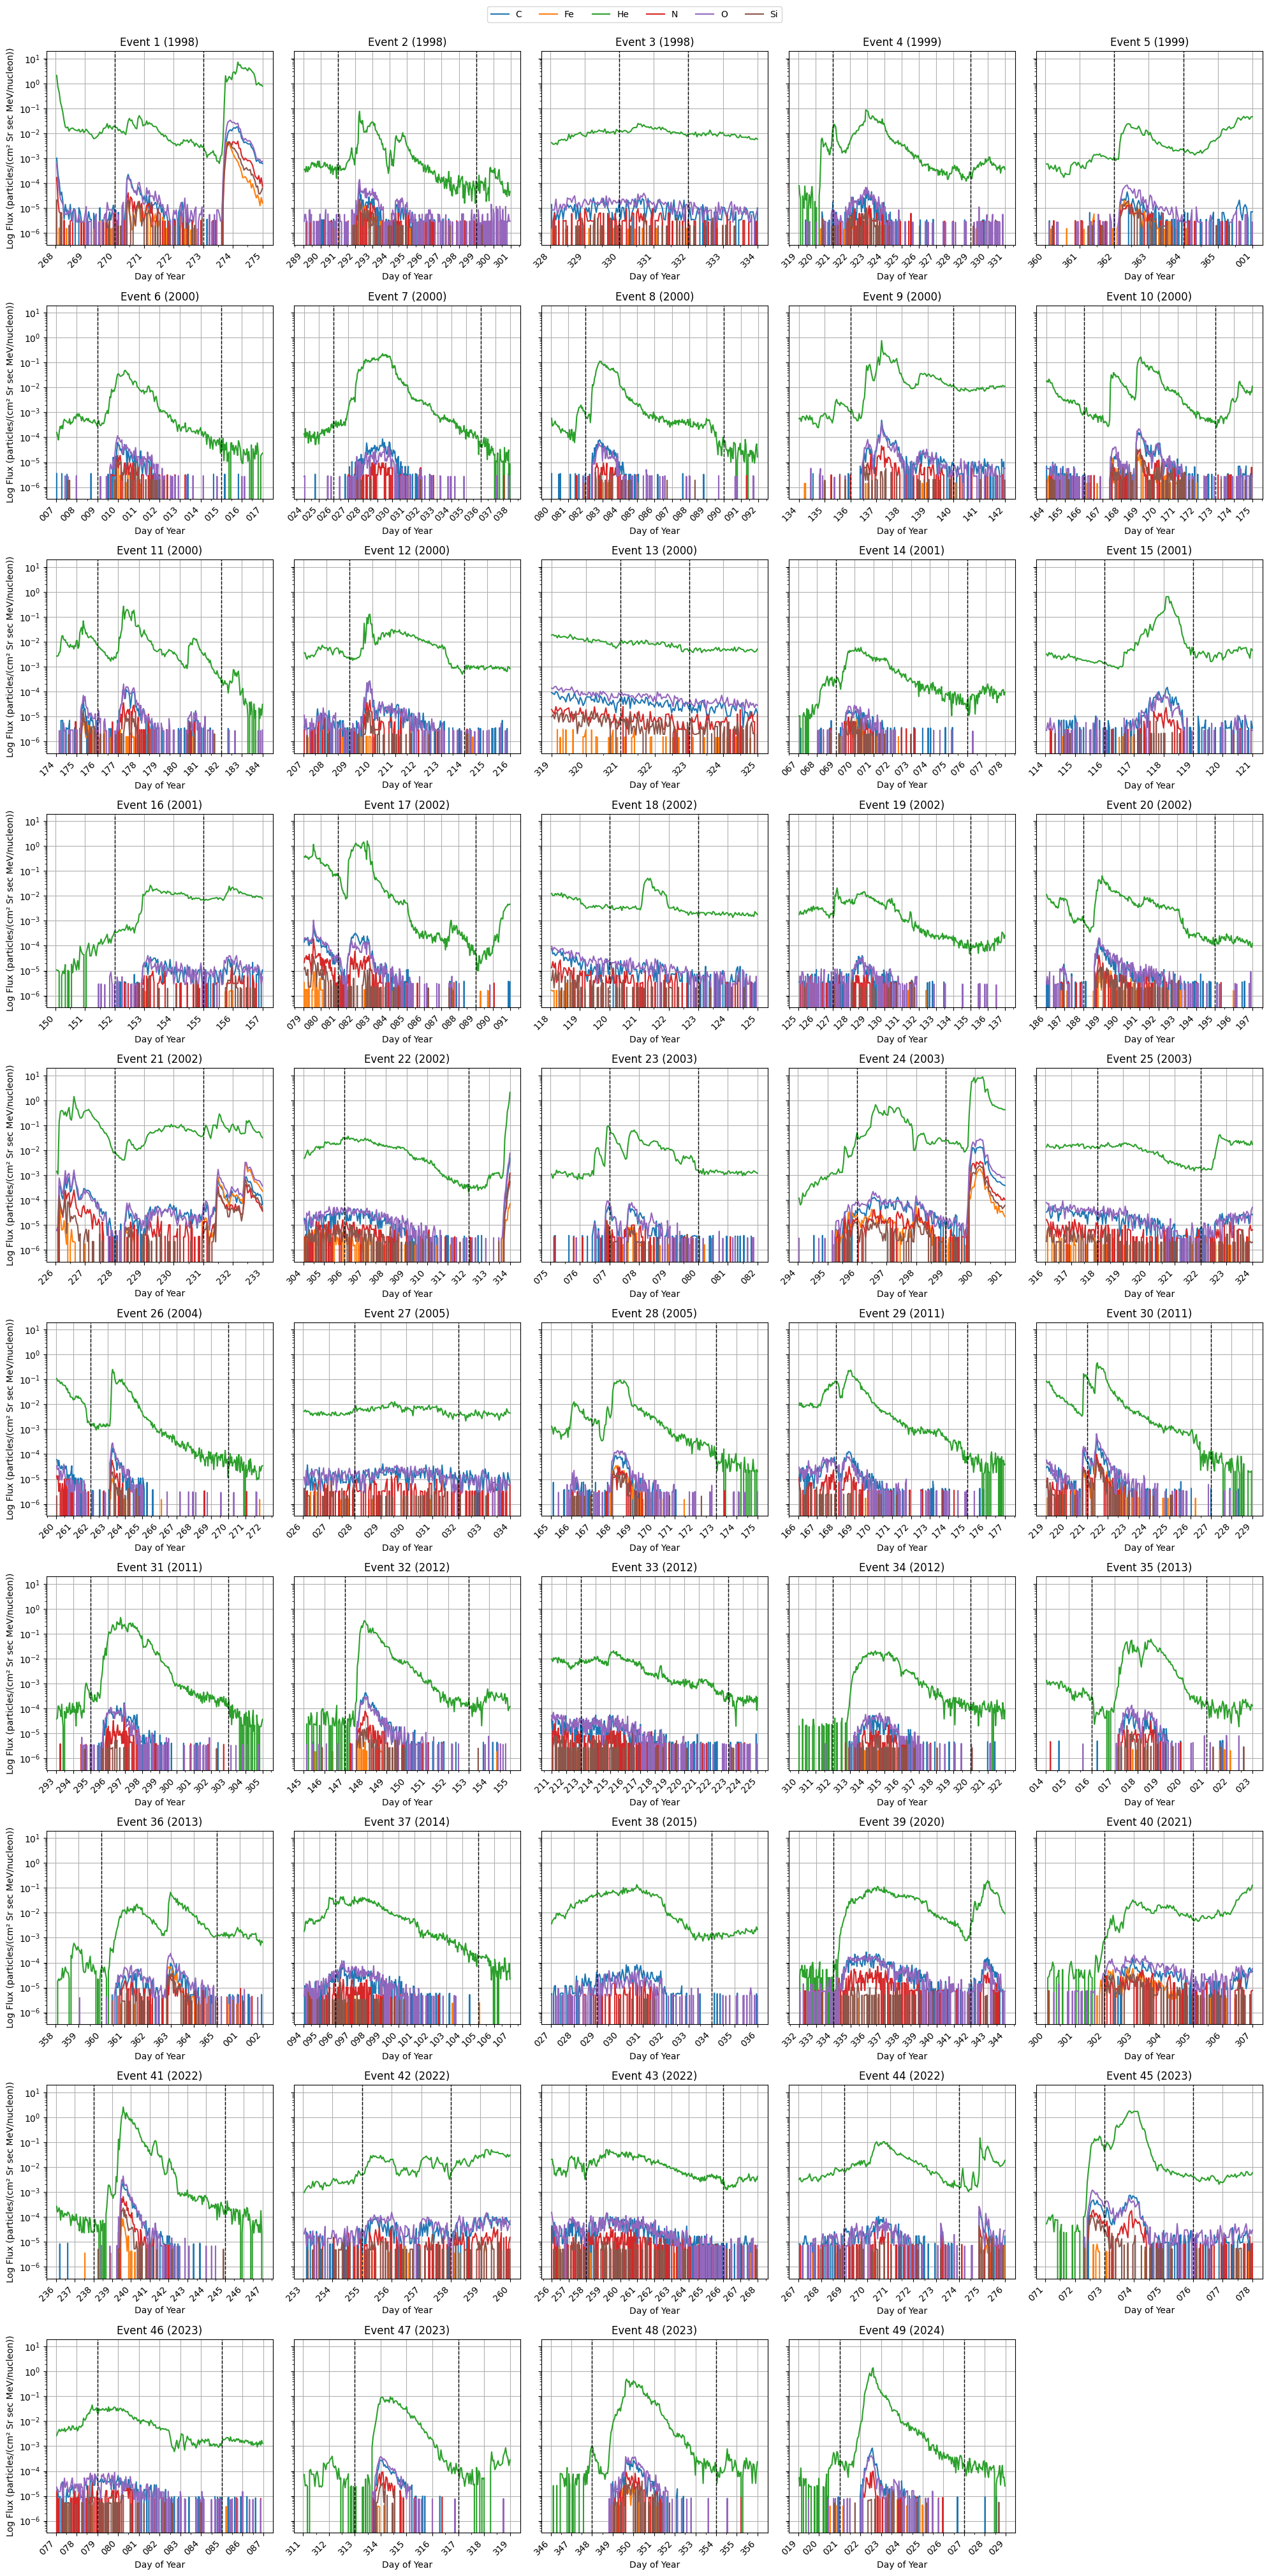

In [19]:
# Plot filtered events
from graph import plot_all_decay_events

energy_level_to_plot = 1
extend_days = 2  # Adjust the number of days to extend before and after
print(f"Graph of flux events using data from energy level {energy_level_to_plot} and using data from Helium at energy level {energy_level_to_plot} for cutoffs")
plot_all_decay_events(filtered_df, all_flux_data, datetime_values, element_mapping, energy_level_to_plot, extend_days, True)


In [8]:
# from graph import plot_decay_events_per_element

# # Parameters
# energy_levels_to_plot = 5  # Number of lowest energy levels to plot
# extend_days = 2  # Extend the time range by 2 days before and after the event
# useLogScale = True  # Whether to use a logarithmic scale for the y-axis

# # Plot the decay events
# plot_decay_events_per_element(filtered_df, all_flux_data, datetime_values, element_mapping, energy_levels_to_plot, extend_days, useLogScale)


---